In [ ]:
!pip install triton
!pip install torch

In [ ]:
import torch

import triton
import triton.language as tl


@triton.jit
def forward_kernel(input_ptr, input_low_ptr, input_range_ptr, output_ptr, levels: int, n_elements:int, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    input = tl.load(input_ptr + offsets, mask=mask)
    input_low = tl.load(input_low_ptr + offsets, mask=mask)
    input_range = tl.load(input_range_ptr + offsets, mask=mask)

    scale = (levels - 1) / input_range
    zero_point = -1 * input_low * scale

    input_max = input_low + input_range
    output = tl.clamp(input, input_low, input_max)
    output -= input_low
    output *= scale
    output -= zero_point
    output = output / scale
    tl.store(output_ptr + offsets, output, mask=mask)


def forward_triton(
    input_: torch.Tensor, input_low: torch.Tensor, input_range: torch.Tensor, levels: int
) -> torch.Tensor:
    output = torch.empty_like(input_)
    n_elements = output.numel()
    BLOCK_SIZE = n_elements
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    forward_kernel[grid](input_, input_low, input_range, output, levels, n_elements, BLOCK_SIZE=1024)
    return output


def forward(
    input_: torch.Tensor, input_low: torch.Tensor, input_range: torch.Tensor, levels: int
) -> torch.Tensor:
    scale = (levels - 1) / input_range
    output = input_.clip(min=input_low, max=input_low + input_range)
    zero_point = (-input_low * scale)
    output -= input_low
    output *= scale
    output -= zero_point
    output = output / scale
    return output


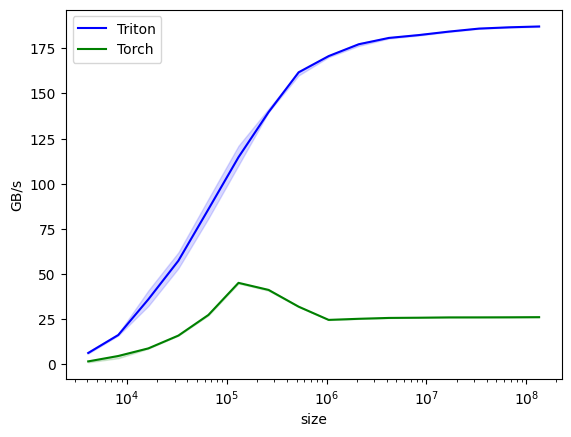

vector-add-performance:
           size      Triton      Torch
0        4096.0    6.360248   1.714286
1        8192.0   16.297081   4.704441
2       16384.0   36.035190   8.904348
3       32768.0   57.420561  15.999999
4       65536.0   85.930071  27.428571
5      131072.0  114.707117  45.176470
6      262144.0  139.636363  41.269522
7      524288.0  161.684218  31.997394
8     1048576.0  170.666661  24.674698
9     2097152.0  177.204154  25.283950
10    4194304.0  180.705879  25.764382
11    8388608.0  182.292371  25.883096
12   16777216.0  184.211171  26.054598
13   33554432.0  185.871033  26.072252
14   67108864.0  186.579351  26.114782
15  134217728.0  187.047049  26.189520


In [ ]:
# https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={},
    ))
def benchmark(size, provider):
    input = torch.rand(size, device='cuda', dtype=torch.float32)
    input_low = torch.rand(size, device='cuda', dtype=torch.float32)
    input_range = torch.rand(size, device='cuda', dtype=torch.float32)
    levels = 10
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: forward(input, input_low, input_range, levels), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: forward_triton(input, input_low, input_range, levels), quantiles=quantiles)
    gbps = lambda ms: 3 * input.numel() * input.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)
